In [1]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


>Checking for null values:

In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

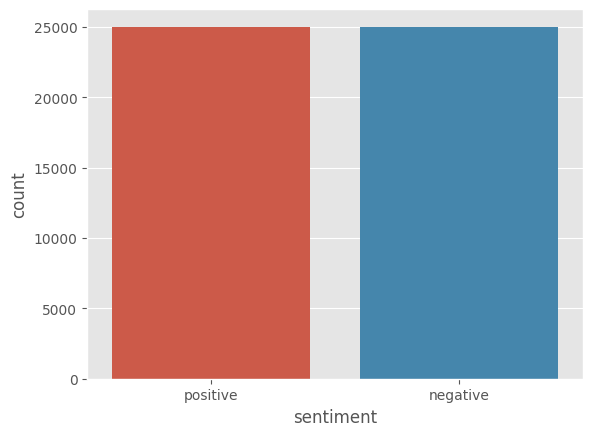

In [5]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [6]:
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

- So, there is no class imbalance both class has an equal number of data.

In [7]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    

class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

In [9]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [10]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [11]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [12]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

> Creating Embedding Layer:

> An embedding layer is typically used to convert words or tokens from a vocabulary into fixed-length dense vectors, often referred to as word embeddings or word vectors. Each word in the vocabulary is assigned a unique vector representation in the embedding space. These word embeddings are learned through the training process, where the model adjusts the values of the vectors to optimize the task at hand, such as sentiment analysis, machine translation, or text generation

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [14]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open("tokenizer.json", 'w', encoding = "utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [15]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

92394

In [16]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [17]:
embedding_dict = dict()
glove_file = open("/kaggle/input/glove6b100dtxt/glove.6B.100d.txt", encoding = 'utf8')
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    words = records[0]
    vector_dimensions = np.asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[words] = vector_dimensions
glove_file.close()

In [18]:
print(list(tokenizer.word_index.items())[:15])

[('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('even', 7), ('would', 8), ('story', 9), ('really', 10), ('see', 11), ('well', 12), ('much', 13), ('bad', 14), ('get', 15)]


In [19]:
embeddings_dictionary.get('film')

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [20]:
embeddings_dictionary['film']

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [21]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(92394, 100)

> Model Building:
>> Simple Neural Network:

In [23]:
snn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(16, activation='relu'))
snn.add(Dense(1,activation = 'sigmoid'))

In [24]:
snn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,399,433
Trainable params: 160,033
Non-trainable params: 9,239,400
_________________________________________________________________


In [25]:
history_snn = snn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 5s 4ms/step - loss: 0.5456 - accuracy: 0.7230 - val_loss: 0.4998 - val_accuracy: 0.7595
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4356 - accuracy: 0.8015 - val_loss: 0.4925 - val_accuracy: 0.7609
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3841 - accuracy: 0.8290 - val_loss: 0.5277 - val_accuracy: 0.7521
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3384 - accuracy: 0.8533 - val_loss: 0.5253 - val_accuracy: 0.7589
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.2970 - accuracy: 0.8767 - val_loss: 0.5516 - val_accuracy: 0.7560
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2568 - accuracy: 0.8950 - val_loss: 0.5904 - val_accuracy: 0.7523
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2119 - accuracy: 0.9191 - val_loss: 0.6523 - val_accuracy: 0.7440
Epoch 

In [26]:
result = snn.evaluate(x_test,y_test, verbose = 1)

313/313 [==============================] - 1s 3ms/step - loss: 0.8892 - accuracy: 0.7341


In [27]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.7340999841690063
Test Loss: 0.8891890645027161


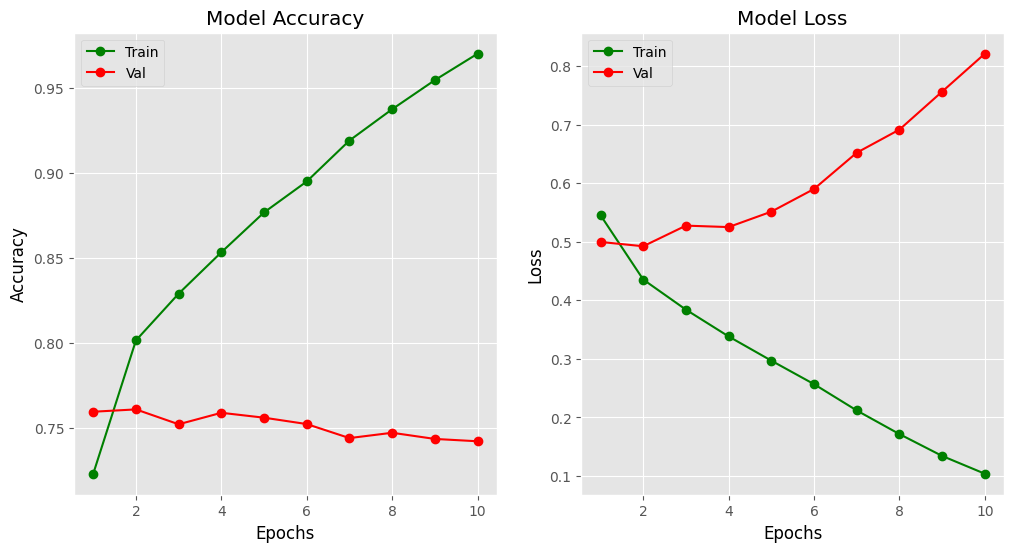

In [28]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_snn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_snn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> Convolutional Neural Network:

In [29]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

In [30]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 dropout (Dropout)           (None, 96, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 256)           164096    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

In [31]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 7s 8ms/step - loss: 0.5087 - accuracy: 0.7437 - val_loss: 0.4206 - val_accuracy: 0.8086
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.3863 - accuracy: 0.8262 - val_loss: 0.3819 - val_accuracy: 0.8267
Epoch 3/10
250/250 [==============================] - 2s 7ms/step - loss: 0.3445 - accuracy: 0.8493 - val_loss: 0.3707 - val_accuracy: 0.8341
Epoch 4/10
250/250 [==============================] - 2s 7ms/step - loss: 0.3072 - accuracy: 0.8712 - val_loss: 0.3385 - val_accuracy: 0.8487
Epoch 5/10
250/250 [==============================] - 2s 8ms/step - loss: 0.2730 - accuracy: 0.8855 - val_loss: 0.3373 - val_accuracy: 0.8505
Epoch 6/10
250/250 [==============================] - 2s 7ms/step - loss: 0.2304 - accuracy: 0.9073 - val_loss: 0.3353 - val_accuracy: 0.8520
Epoch 7/10
250/250 [==============================] - 2s 7ms/step - loss: 0.1971 - accuracy: 0.9221 - val_loss: 0.3547 - val_accuracy: 0.8489
Epoch 

In [32]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

313/313 [==============================] - 1s 3ms/step - loss: 0.3954 - accuracy: 0.8495
Test Accuracy: 0.8495000004768372
Test Loss: 0.395412802696228


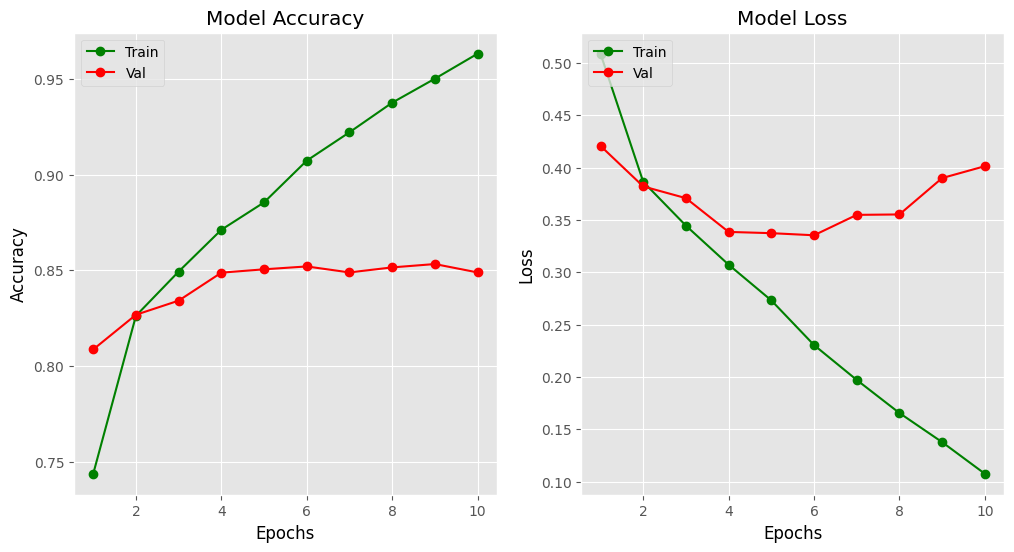

In [33]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> LSTM

In [38]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(128)) #return_sequences=True
# lstm.add(LSTM(64, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(32))


# cnn.add(Conv1D(256,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [39]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [40]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 5s 15ms/step - loss: 0.5044 - accuracy: 0.7545 - val_loss: 0.4153 - val_accuracy: 0.8146
Epoch 2/10
250/250 [==============================] - 3s 13ms/step - loss: 0.4136 - accuracy: 0.8132 - val_loss: 0.4008 - val_accuracy: 0.8249
Epoch 3/10
250/250 [==============================] - 3s 13ms/step - loss: 0.3715 - accuracy: 0.8381 - val_loss: 0.3578 - val_accuracy: 0.8444
Epoch 4/10
250/250 [==============================] - 3s 13ms/step - loss: 0.3411 - accuracy: 0.8539 - val_loss: 0.3584 - val_accuracy: 0.8495
Epoch 5/10
250/250 [==============================] - 3s 14ms/step - loss: 0.3269 - accuracy: 0.8612 - val_loss: 0.3863 - val_accuracy: 0.8269
Epoch 6/10
250/250 [==============================] - 3s 13ms/step - loss: 0.3092 - accuracy: 0.8722 - val_loss: 0.3150 - val_accuracy: 0.8716
Epoch 7/10
250/250 [==============================] - 3s 13ms/step - loss: 0.2951 - accuracy: 0.8771 - val_loss: 0.3200 - val_accuracy: 0.8611

In [41]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

313/313 [==============================] - 1s 5ms/step - loss: 0.3182 - accuracy: 0.8692
Test Accuracy: 0.8691999912261963
Test Loss: 0.3181903064250946


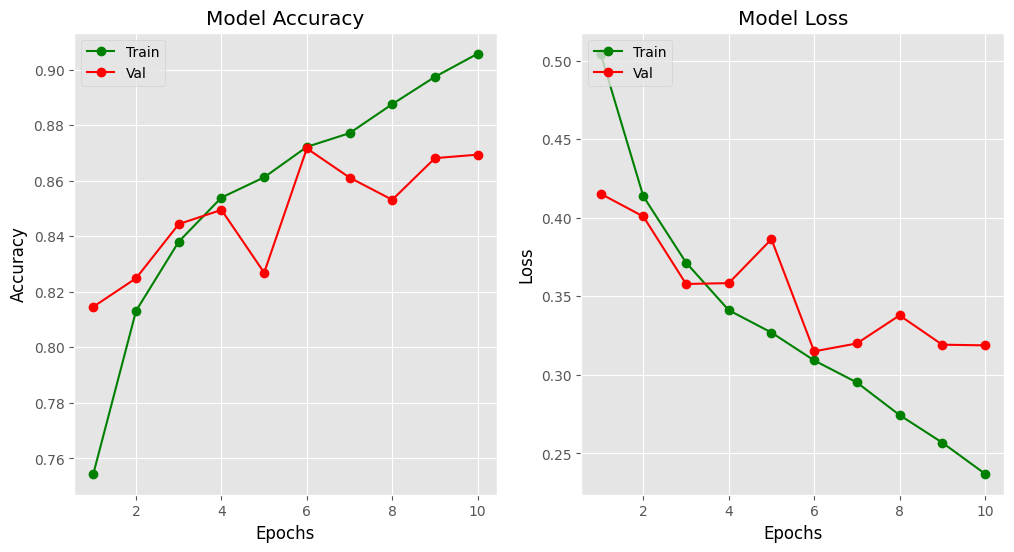

In [43]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [44]:
lstm.save("sentiment_classifier2.h5")